In [1]:
import numpy as np
from dLdp import analytic_dLdp
from matplotlib import pyplot as plt
from matplotlib import style
from functools import partial

In [2]:
def plot_trajectories(q_traj,p_trajs,n_p):
    style.use('fivethirtyeight')
    p_trajs=p_trajs.reshape(-1,n_p,2)
    plt.plot(q_traj[0,:],q_traj[1,:],'*',label="Target")
    for i in range(n_p):
        plt.plot(p_trajs[:,i,0],p_trajs[:,i,1],'.',label="Mobile Sensor {}".format(i))
    plt.legend()
    plt.show()


In [4]:
sigma=1.
C0s=np.array([0.,0.,0.])
C1s=np.array([0.1,0.1,0.1])
ks=np.array([1.5,0.5,1.])
bs=np.array([-2,-2,-2])

q=np.array([0.,0.])
ps=np.array([[1.,0],[0,1.],[-1,0.0]])


In [5]:
q_traj=q[...,np.newaxis]
p_trajs=ps[...,np.newaxis]

# Path Planning with constant step size. That is $||\alpha_i \nabla_{p_i}L||=constant$

In [5]:
def polar_projection(q,ps,r):    
    """ 
        Return the projection of a set of points ps onto a circle centered at q with radius r
    """
    q=q.reshape(-1,2)
    ps=ps.reshape(-1,2)
    dists=np.linalg.norm(ps-q,axis=1)

    dists[dists==0]=1 # Handling the zero distances
    ps_proj=((ps-q).T/dists * r).T +q
    return ps_proj

def FIM_ascent_path_planning(f_dLdp,q,ps,n_p,n_timesteps,max_linear_speed,dt,epsilon):
    """
        f_dLdp: a function handle, f_dLdp(q,ps)=dLdp.
        q: Current location of the target.
        ps: Current locations of the mobile sensors.
        n_p: The number of sensors
        n_timesteps: The number of timesteps to plan ahead. The total time horizon T will be T=n_timesteps*dt.
        
        max_linear_speed: the linear speed limit to be set on the mobile sensors.
        dt: the time differences between two consecutive waypoints.
        
        The update step size will be a constant = max_linear_speed * dt
        
        epsilon: when the planned trajectories end, how far away should they be to the target.
    """

    step_size=max_linear_speed*dt
    p_trajs=[]
    
    q=q.reshape(-1,2)
    ps=ps.reshape(-1,2)
    p_trajs.append(ps)
    for i in range(n_timesteps):
        # Calculate the gradient
        grad=f_dLdp(q,ps)
        grad=grad.reshape(-1,2)
        grad_sizes=np.linalg.norm(grad,axis=1)

        grad_sizes[grad_sizes==0]=1 # Handle the case where the partial derivative is zero.

        update_steps=(grad.T/grad_sizes * step_size).T # Calculate the update steps to be applied to ps

        candid_ps=ps+update_steps # Calculate the direct update before projecting onto the target sphere.

        # Project candid_ps onto the "surveillance circle" once it steps into it
        if not np.all(np.linalg.norm(candid_ps-q,axis=1)>=epsilon):
            insiders=np.linalg.norm(candid_ps-q,axis=1)<epsilon
            ps=candid_ps
            ps[insiders]=polar_projection(q,candid_ps,epsilon)[insiders] # Update ps.
            p_trajs.append(ps)
            break # Exit the loop
        else:
            ps=candid_ps # Update ps.
            p_trajs.append(ps)
    return np.array(p_trajs).reshape(-1,n_p,2) # Shape= (num_time_steps,num_sensors,2)

# A typical working example

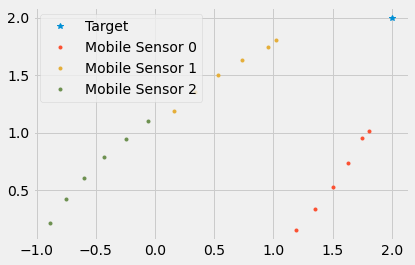

In [20]:
max_linear_speed=1.22
dt=0.2
epsilon=1
sigma=1.
C0s=np.array([0.,0.,0.])
C1s=np.array([0.1,0.1,0.1])
ks=np.array([1.5,0.5,1.])
bs=np.array([-2,-2,-2])

q=np.array([2,2])
ps=np.array([[1.,0],[0,1.],[-1,0.0]])

n_p=3
n_timesteps=100

f_dLdp=partial(analytic_dLdp,sigma=sigma,C1s=C1s,C0s=C0s,ks=ks,bs=bs)

p_trajs=FIM_ascent_path_planning(f_dLdp,q,ps,n_p,n_timesteps,max_linear_speed,dt,epsilon)

q_traj=q[...,np.newaxis]

plot_trajectories(q_traj,p_trajs,3)

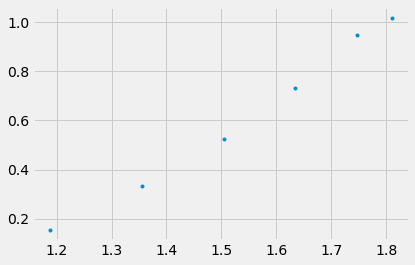

In [21]:
plt.plot(p_trajs[:,0,0],p_trajs[:,0,1],'.')

In [147]:
BURGER_MAX_LIN_VEL = 0.22
BURGER_MAX_ANG_VEL = 2.84

def unscaled_2D_spline_motion(waypoints,poly_order, state_space_dim):
    
    # Local Helper Functions
    def fit_spatial_polynomial(waypoints,poly_order, state_space_dim):
        """
            Fit a spatial polynomial p(s)-> R^state_space_dim, s in 0~1, to fit the waypoints.
        """
        if waypoints.shape[1]!=state_space_dim:
            waypoints=waypoints.T

        assert(waypoints.shape[1]==state_space_dim)

        n = waypoints.shape[0]

        s = np.array([i/(n-1) for i in range(n)])
        S = np.vstack([np.power(s,k) for k in range(poly_order+1)])
        S = S.T

        # The two formulas below are equivalent if S is full rank.
    #     poly_coefs= np.linalg.inv(S.dot(S.T))).dot(waypoints)
        poly_coefs = np.linalg.pinv(S).dot(waypoints)
        return poly_coefs,S

    # A debug-purpose function.
    # def polynomial(poly_coefs,x):
    #     '''
    #         Evaluate the value of the polynomial specified by poly_coefs at locations x.
    #     '''
    #     S = np.vstack([np.power(x,k) for k in range(len(poly_coefs))])
    #     y = np.array(poly_coefs).dot(S)
    #     return y

    def diff_poly_coefs(poly_coefs):
        '''
            Calculate the coefs of the polynomial after taking the first-order derivative.
        '''
        if len(poly_coefs)==1:
            coefs = [0]
        else:
            coefs = np.array(range(len(poly_coefs)))*poly_coefs
            coefs = coefs[1:]
        return coefs
    ######### End of Helper Functions #################################

    coef,S = fit_spatial_polynomial(waypoints,poly_order, state_space_dim)
    # coef.shape = (poly_order+1,state_space_dim)
    # S.shape = (n_waypoints,poly_order+1), 
    # S = [[1,s_i,s_i^2,s_i^3,...,s_i^poly_order]]_{i=0...n_waypoints}, s_i = i/n_waypoints
    
    dotCoef = np.vstack([diff_poly_coefs(coef[:,i]) for i in range(state_space_dim)]).T
    # dotCoef.shape = (poly_order,state_space_dim)
    
    ddotCoef = np.vstack([diff_poly_coefs(dotCoef[:,i]) for i in range(state_space_dim)]).T
    # ddotCoef.shape = (poly_order-1,state_space_dim)
    
    p = S[:,:poly_order+1].dot(coef)
    # p.shape = (n_waypoints,state_space_dim)
    
    pDot = S[:,:poly_order].dot(dotCoef)
    # pDot.shape = (n_waypoints,state_space_dim)
    
    pDDot = S[:,:poly_order-1].dot(ddotCoef)
    # pDot.shape = (n_waypoints,state_space_dim)
    
    theta = np.arctan2(pDot[:,1],pDot[:,0])
    # The facing angles at each p, shape=(n_waypoints,)
    
    v= np.linalg.norm(pDot,axis=1)
    # The velocity, derivative in s. shape = (n_waypoints,)
    
    omega = (pDDot[:,1]*pDot[:,0]-pDDot[:,0]*pDot[:,1])/np.power(v,2)
    # The angular velocity, rotating counter-clockwise as positive. shape=(n_waypoints,)
    return p,pDot,pDDot,theta,v,omega
def scaled_2D_spline_motion(waypoints,poly_order, state_space_dim):
    Vm = BURGER_MAX_LIN_VEL
    Om = BURGER_MAX_ANG_VEL
    
    p,pDot,pDDot,theta,v,omega = unscaled_2D_spline_motion(waypoints,poly_order, state_space_dim)
    
    dsdt = np.min([Vm/np.abs(v),Om/np.abs(omega)],axis=0)
#   dsdt is the scaling factor to be multiplied on v and omega, so that they do not exceed the maximal velocity limit.
    
    v*=dsdt
    omega*=dsdt
    
    return p,theta,v,omega,dsdt

In [180]:
waypoints = p_trajs[:,1,:]
poly_order=3
state_space_dim=2
p,pDot,pDDot,theta,v,omega=unscaled_2D_spline_motion(waypoints,poly_order, state_space_dim)

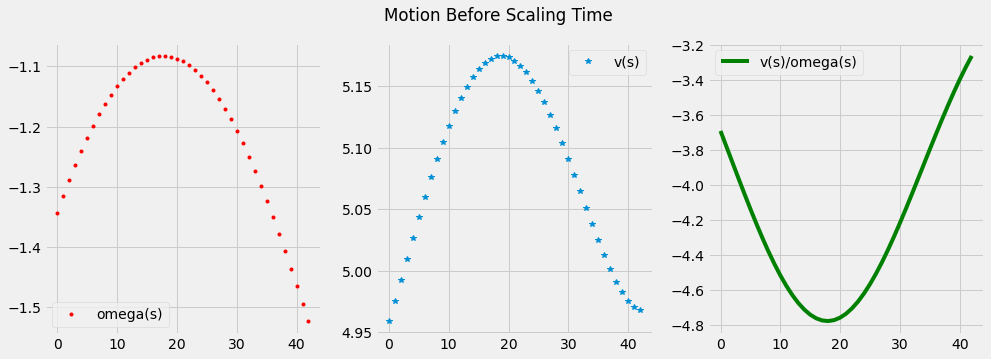

In [181]:
plt.figure(figsize=(15,5))
plt.suptitle('Motion Before Scaling Time')
plt.subplot(1,3,1)
plt.plot(omega,'.',label='omega(s)',color='r')
plt.legend()
plt.subplot(1,3,2)
plt.plot(v,'*',label='v(s)')
plt.legend()
plt.subplot(1,3,3)
plt.plot(v/omega,label='v(s)/omega(s)',color='g')
plt.legend()

In [182]:
p,theta,v,omega,dsdt=scaled_2D_spline_motion(waypoints,poly_order, state_space_dim)

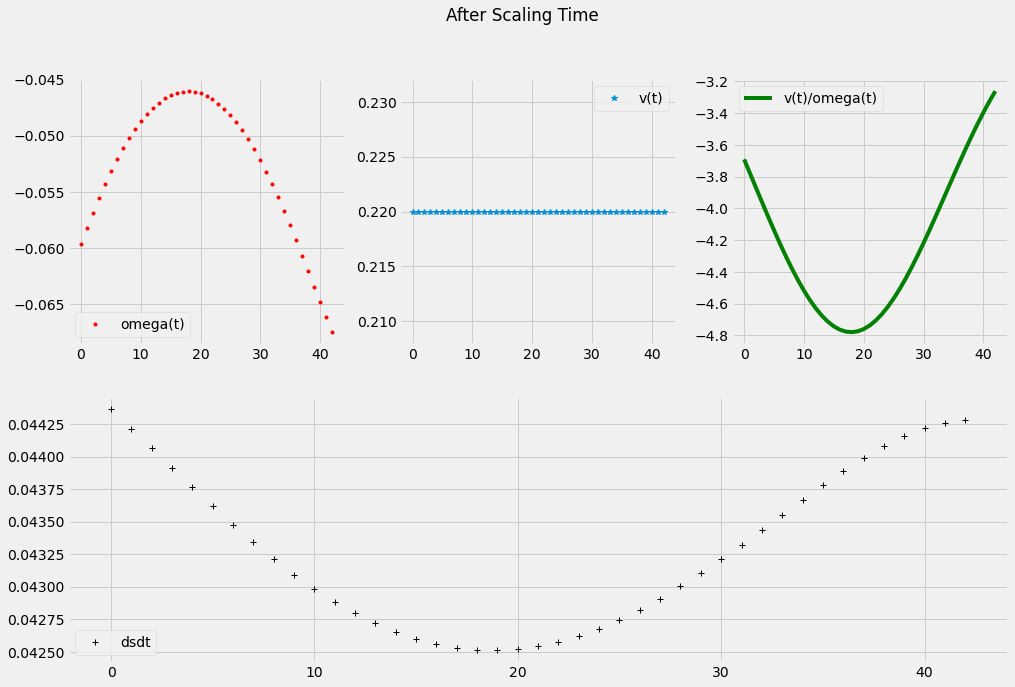

In [183]:
plt.figure(figsize=(15,10))
plt.suptitle('After Scaling Time')

plt.subplot(2,1,2)
plt.plot(dsdt,'+',label='dsdt',color='black')
plt.legend()

plt.subplot(2,3,1)
plt.plot(omega,'.',label='omega(t)',color='r')
plt.legend()
plt.subplot(2,3,2)
plt.plot(v,'*',label='v(t)')
plt.legend()
plt.subplot(2,3,3)
plt.plot(v/omega,label='v(t)/omega(t)',color='g')
plt.legend()


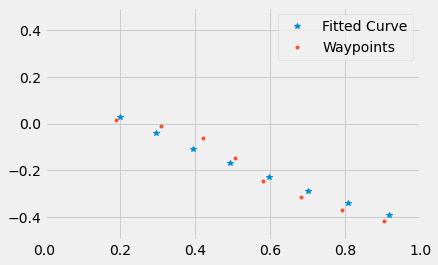

In [185]:
plt.plot(p[:,0],p[:,1],'*',label='Fitted Curve')
plt.plot(waypoints[:,0],waypoints[:,1],'.',label='Waypoints')
plt.xlim((0,1))
plt.ylim((-0.5,0.5))
plt.legend()

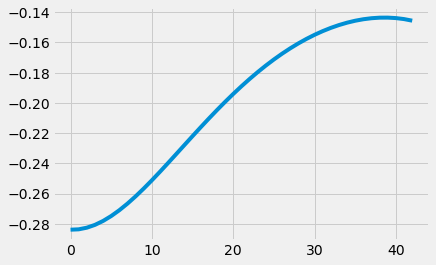

In [121]:
plt.plot(omega/v)

In [100]:
omega/np.pi * 180

array([-3.57909799, -3.57601607, -3.56241486, -3.53888443, -3.50614924,
       -3.46504015, -3.41646499, -3.36137951, -3.30075995, -3.23557833,
       -3.16678125, -3.09527256, -3.02190002, -2.94744584, -2.87262082,
       -2.7980616 , -2.72433053, -2.65191771, -2.58124464, -2.51266904,
       -2.44649047, -2.3829564 , -2.32226839, -2.26458834, -2.21004449,
       -2.15873715, -2.11074409, -2.06612557, -2.02492892, -1.98719282,
       -1.95295125, -1.92223704, -1.8950853 , -1.87153657, -1.85163986,
       -1.83545563, -1.8230587 , -1.8145413 , -1.81001616, -1.8096199 ,
       -1.81351662, -1.8219019 , -1.83500735])

In [101]:
v

array([0.22, 0.22, 0.22, 0.22, 0.22, 0.22, 0.22, 0.22, 0.22, 0.22, 0.22,
       0.22, 0.22, 0.22, 0.22, 0.22, 0.22, 0.22, 0.22, 0.22, 0.22, 0.22,
       0.22, 0.22, 0.22, 0.22, 0.22, 0.22, 0.22, 0.22, 0.22, 0.22, 0.22,
       0.22, 0.22, 0.22, 0.22, 0.22, 0.22, 0.22, 0.22, 0.22, 0.22])

In [102]:
theta/np.pi * 180

array([ 34.01011262,  31.97638956,  29.96097132,  27.96759389,
        25.99967756,  24.06029727,  22.15216245,  20.27760595,
        18.43858159,  16.63666937,  14.87308729,  13.14870852,
        11.46408275,   9.81946049,   8.21481925,   6.64989056,
         5.12418703,   3.63702883,   2.1875689 ,   0.77481667,
        -0.60234015,  -1.94511573,  -3.25480846,  -4.53278532,
        -5.7804684 ,  -6.99932339,  -8.19084994,  -9.35657387,
       -10.49804092, -11.61681215, -12.71446064, -13.79256954,
       -14.85273129, -15.89654796, -16.92563264, -17.94161173,
       -18.94612824, -19.94084602, -20.92745478, -21.90767618,
       -22.88327071, -23.85604572, -24.82786436])

In [16]:
pDDot.shape

(7, 2)

In [17]:
x= np.linspace(-3,3,100)

coef=[0,0,-3,0,3]
plt.plot(x,polynomial(coef,x))

coef=diff_poly_coefs(coef)
plt.plot(x,polynomial(coef,x))

coef=diff_poly_coefs(coef)
plt.plot(x,polynomial(coef,x))

coef=diff_poly_coefs(coef)
plt.plot(x,polynomial(coef,x))

coef=diff_poly_coefs(coef)
plt.plot(x,polynomial(coef,x))

coef=diff_poly_coefs(coef)
plt.plot(x,polynomial(coef,x))

coef=diff_poly_coefs(coef)
plt.plot(x,polynomial(coef,x))



NameError: name 'polynomial' is not defined

In [18]:
waypoints = p_trajs[:,1,:]

poly_order = 3
state_space_dim = 2

coefs,S = fit_spatial_polynomial(waypoints,poly_order,2)

fitted_curve = S.dot(coefs)

plt.plot(fitted_curve[:,0],fitted_curve[:,1],'*')
plt.plot(waypoints[:,0],waypoints[:,1],'.')


NameError: name 'fit_spatial_polynomial' is not defined

# Allowing more time steps and smaller epsilon

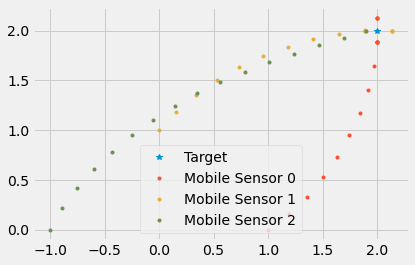

In [19]:
max_linear_speed=1.22
dt=0.2
epsilon=0.1
sigma=1.
C0s=np.array([0.,0.,0.])
C1s=np.array([0.1,0.1,0.1])
ks=np.array([1.5,0.5,1.])
bs=np.array([-2,-2,-2])

q=np.array([2,2])
ps=np.array([[1.,0],[0,1.],[-1,0.0]])

n_p=3
n_timesteps=50

f_dLdp=partial(analytic_dLdp,sigma=sigma,C1s=C1s,C0s=C0s,ks=ks,bs=bs)

p_trajs=FIM_ascent_path_planning(f_dLdp,q,ps,n_p,n_timesteps,max_linear_speed,dt,epsilon)

q_traj=q[...,np.newaxis]

plot_trajectories(q_traj,p_trajs,3)

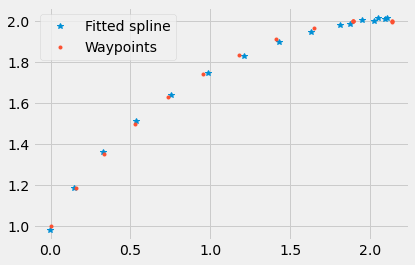

In [13]:
waypoints = p_trajs[:,1,:]

poly_order = 3
state_space_dim = 2

coefs,S = fit_spatial_polynomial(waypoints,poly_order,2)

fitted_curve = S.dot(coefs)

plt.plot(fitted_curve[:,0],fitted_curve[:,1],'*',label='Fitted spline')
plt.plot(waypoints[:,0],waypoints[:,1],'.',label='Waypoints')
plt.legend()

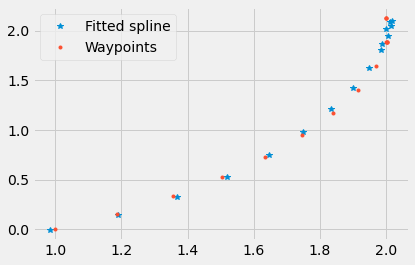

In [14]:
waypoints = p_trajs[:,0,:]

poly_order = 3
state_space_dim = 2

coefs,S = fit_spatial_polynomial(waypoints,poly_order,2)

fitted_curve = S.dot(coefs)

plt.plot(fitted_curve[:,0],fitted_curve[:,1],'*',label='Fitted spline')
plt.plot(waypoints[:,0],waypoints[:,1],'.',label='Waypoints')
plt.legend()

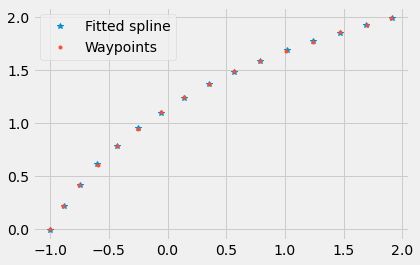

In [15]:
waypoints = p_trajs[:,2,:]

poly_order = 3
state_space_dim = 2

coefs,S = fit_spatial_polynomial(waypoints,poly_order,2)

fitted_curve = S.dot(coefs)

plt.plot(fitted_curve[:,0],fitted_curve[:,1],'*',label='Fitted spline')
plt.plot(waypoints[:,0],waypoints[:,1],'.',label='Waypoints')
plt.legend()

# Plan very far ahead, using the imported version of the function

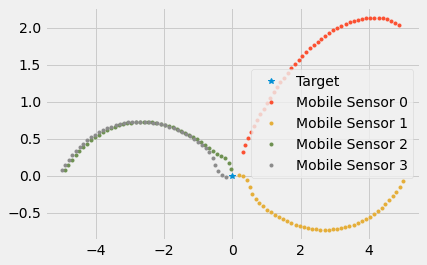

In [179]:
from FIMPathPlanning import FIM_ascent_path_planning
from dLdp import analytic_dLdp
from functools import partial
max_linear_speed=1.22
dt=0.1
epsilon=0.1
sigma=1.
C0s=np.array([0.,0.,0.,0])
C1s=np.array([0.1,0.1,0.1,0.1])
ks=np.array([1.5,0.5,1.,1.1])
bs=np.array([-2,-2,-2,-2])

q=np.array([-0,-0])
ps=np.array([[5.,2],[5.1,-0],[-5,0.0],[-5.1,-0.0]])

n_p=len(ps)
n_timesteps=100

f_dLdp=partial(analytic_dLdp,sigma=sigma,C1s=C1s,C0s=C0s,ks=ks,bs=bs)

p_trajs=FIM_ascent_path_planning(f_dLdp,q,ps,n_p,n_timesteps,max_linear_speed,dt,epsilon)

q_traj=q[...,np.newaxis]

plot_trajectories(q_traj,p_trajs,n_p)

In [7]:
waypoints = p_trajs[:,2,:]

poly_order = 3
state_space_dim = 2

coefs,S = fit_spatial_polynomial(waypoints,poly_order,2)

fitted_curve = S.dot(coefs)

plt.plot(fitted_curve[:,0],fitted_curve[:,1],'*',label='Fitted spline')
plt.plot(waypoints[:,0],waypoints[:,1],'.',label='Waypoints')
plt.legend()

NameError: name 'fit_spatial_polynomial' is not defined

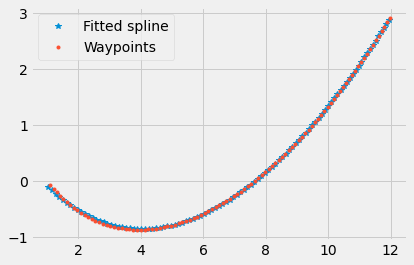

In [21]:
waypoints = p_trajs[:,0,:]

poly_order = 3
state_space_dim = 2

coefs,S = fit_spatial_polynomial(waypoints,poly_order,2)

fitted_curve = S.dot(coefs)

plt.plot(fitted_curve[:,0],fitted_curve[:,1],'*',label='Fitted spline')
plt.plot(waypoints[:,0],waypoints[:,1],'.',label='Waypoints')
plt.legend()

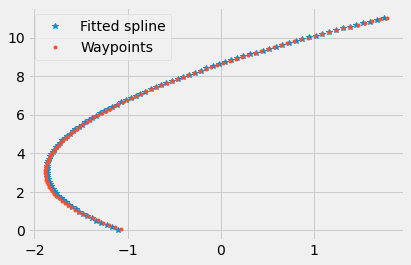

In [23]:
waypoints = p_trajs[:,2,:]

poly_order = 3
state_space_dim = 2

coefs,S = fit_spatial_polynomial(waypoints,poly_order,2)

fitted_curve = S.dot(coefs)

plt.plot(fitted_curve[:,0],fitted_curve[:,1],'*',label='Fitted spline')
plt.plot(waypoints[:,0],waypoints[:,1],'.',label='Waypoints')
plt.legend()

# With n_timestep <=100, the path planing is very fast.